## Kyle Decker
STA561 -  Probabilistic Machine Learning  
Kaggle Competition Writeup

## Import libraries

In [2]:
import pandas as pd  
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.neural_network import MLPRegressor
import time
import warnings
import pylab
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')

## Read in data and perform minor preprocessing

In [3]:
# Read in training and test data
train_tmp = pd.read_csv('pml_train.csv')
test_tmp = pd.read_csv('pml_test_features.csv')

# Drop the loss col temporarily in order to merge data frames
loss = train_tmp['loss']
train_tmp.drop(labels=['loss'], axis=1,inplace = True)

# Cat the training and test in order to convert categorical vars to dummies
frames = [train_tmp,test_tmp]
data_tmp = pd.concat(frames) 

# Convert categorical features to dummy vars
data_dummy = pd.get_dummies(data_tmp)

# Split back in to train and test
train_size = len(train_tmp['id'])
train = data_dummy.iloc[0:train_size,:]
test = data_dummy.iloc[train_size:,:]


## Exploratory analysis and Feature Reduction

In [ ]:
# Get some summary stats
train.describe()

In [4]:
# Drop the categorical features that have very few instances (<10000)
cols_to_drop = []
for i in range(len(train.iloc[1])):
    if (np.count_nonzero(train.iloc[:,i]) < 10000):
        cols_to_drop = np.append(cols_to_drop,i)
train.drop(train.columns[cols_to_drop.astype(int)],axis=1,inplace = True)
test.drop(test.columns[cols_to_drop.astype(int)],axis=1,inplace = True)

# Move the loss to column 0
train.insert(0, 'loss', loss)

# randomly partition data into train_sub (80%) and cross_val (20%) sets
train_sub,cross_val = train_test_split(train, test_size=.2)

In [ ]:
len(train.iloc[1])

In [ ]:
# Scatter plot of continuous vars
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14) = plt.subplots(14, sharex=True, sharey=True)
ax1.scatter(train['cont1'],train['loss'])
f, (ax1).title.set_text('cont1')
ax2.scatter(train['cont2'],train['loss'])
f, (ax2).title.set_text('cont2')
ax3.scatter(train['cont3'],train['loss'])
f, (ax3).title.set_text('cont3')
ax4.scatter(train['cont4'],train['loss'])
f, (ax4).title.set_text('cont4')
ax5.scatter(train['cont5'],train['loss'])
f, (ax5).title.set_text('cont5')
ax6.scatter(train['cont6'],train['loss'])
f, (ax6).title.set_text('cont6')
ax7.scatter(train['cont7'],train['loss'])
f, (ax7).title.set_text('cont6')
ax8.scatter(train['cont8'],train['loss'])
f, (ax8).title.set_text('cont8')
ax9.scatter(train['cont9'],train['loss'])
f, (ax9).title.set_text('cont9')
ax10.scatter(train['cont10'],train['loss'])
f, (ax10).title.set_text('cont10')
ax11.scatter(train['cont11'],train['loss'])
f, (ax11).title.set_text('cont11')
ax12.scatter(train['cont12'],train['loss'])
f, (ax12).title.set_text('cont12')
ax13.scatter(train['cont13'],train['loss'])
f, (ax13).title.set_text('cont13')
ax14.scatter(train['cont14'],train['loss'])
f, (ax14).title.set_text('cont14')

## Some features seem highly correlated

cont11 and cont12 are highly correlated with r2 score of 0.988691


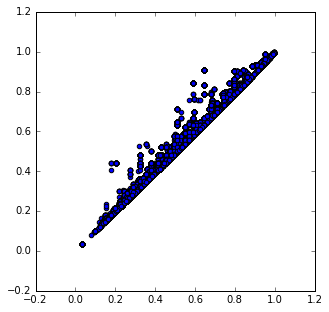

In [5]:
# Plot two variables against eachother that seem correlated
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(train['cont11'],train['cont12'])
# Determine correlation r2 between the two variables
r2 = r2_score(train['cont11'],train['cont12'])
print('cont11 and cont12 are highly correlated with r2 score of %f' %r2)
# PCA should take care of these but lets drop one of them just in case
train.drop(labels=['cont11'], axis=1,inplace = True)
train_sub.drop(labels=['cont11'], axis=1,inplace = True)
cross_val.drop(labels=['cont11'], axis=1,inplace = True)
test.drop(labels=['cont11'], axis=1,inplace = True)

## PCA to perform dimensionality reduction and take care of correlated features

In [ ]:
# PCA
pca= decomposition.PCA(n_components=75)
train_pca = pca.fit_transform(train.iloc[:,2:])
train_sub_pca = pca.transform(train_sub.iloc[:,2:])
cross_val_pca = pca.transform(cross_val.iloc[:,2:])
test_pca = pca.transform(test.iloc[:,1:])

## Random Forest Model

In [ ]:
# Random Forest Regression
#rf = RandomForestRegressor(n_estimators = 5, criterion='mse',min_samples_leaf=10,max_features = 100, random_state = 3)
rf = RandomForestRegressor(n_estimators = 1000, criterion='mse',min_samples_leaf=10,min_samples_split=50,max_features = 100, random_state = 3)
#rf = RandomForestRegressor(n_estimators = 100, criterion='mse',min_samples_split=40,min_samples_leaf=20,max_features = 40, random_state = 3)
#rf = RandomForestRegressor(n_estimators = 5, criterion='mse',min_samples_leaf=15,max_features = 100) 

start_time = time.time()
# train the model
rf.fit(train_sub.iloc[:,2:],train_sub.iloc[:,0])
#rf.fit(train_sub_pca,train_sub.iloc[:,0])
elapsed_time = time.time() - start_time
print('Model trained in  %f seconds' % elapsed_time)

# predict the loss for training and cross validation
loss_pred_train = rf.predict(train_sub.iloc[:,2:])
#loss_pred_train = rf.predict(train_sub_pca)
MAE_train = mean_absolute_error(train_sub.iloc[:,0],loss_pred_train)
print('MAE on training set = %f' % MAE_train)

loss_pred_cv = rf.predict(cross_val.iloc[:,2:])
#loss_pred_cv = rf.predict(cross_val_pca)
MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

In [ ]:
# Choose Number of Trees
trees = [1,3,10,30,100]
train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(trees)):
    rf = RandomForestRegressor(n_estimators = trees[i], random_state = 3)
    rf.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = rf.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = rf.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

pylab.plot(trees,train_error_all,'b--',label='training')
pylab.plot(trees,cv_error_all,'r--',label='cross-validation')
pylab.legend(loc='upper right')
pylab.xlabel('Number of trees')
pylab.ylabel('MAE')

In [ ]:
# Choose Min Samples to Split
splits = [2,4,16,40,100]
train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(trees)):
    rf = RandomForestRegressor(n_estimators = 100, min_samples_split=splits[i], random_state = 3)
    rf.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = rf.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = rf.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

pylab.plot(splits,train_error_all,'b--',label='training')
pylab.plot(splits,cv_error_all,'r--',label='cross-validation')
pylab.legend(loc='upper right')
pylab.xlabel('Min Samples to Split')
pylab.ylabel('MAE')

In [ ]:
# Choose Min Samples at Leaf
leaf = [1,3,10,30,100]
train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(trees)):
    rf = RandomForestRegressor(n_estimators = 100, min_samples_split=100,min_samples_leaf=leaf[i], random_state = 3)
    rf.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = rf.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = rf.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

pylab.plot(leaf,train_error_all,'b--',label='training')
pylab.plot(leaf,cv_error_all,'r--',label='cross-validation')
pylab.legend(loc='upper right')
pylab.xlabel('Min Samples at Leaf')
pylab.ylabel('MAE')

In [ ]:
# Choose Max Features to consider
feat = [2,4,16,40,100]
train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(trees)):
    rf = RandomForestRegressor(n_estimators = 100, min_samples_split=100,min_samples_leaf=20,max_features = feat[i], random_state = 3)
    rf.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = rf.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = rf.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

pylab.plot(feat,train_error_all,'b--',label='training')
pylab.plot(feat,cv_error_all,'r--',label='cross-validation')
pylab.legend(loc='upper right')
pylab.xlabel('Max Features to Consider for Split')
pylab.ylabel('MAE')

In [ ]:
# Try on the test set and make kaggle output
loss_pred_test = rf.predict(test.iloc[:,1:])
#loss_pred_test = rf.predict(test_pca)

test_results_id = test['id']
test_results_loss = loss_pred_test

# Create results data frame
test_df = pd.DataFrame(data=test_results_id)
test_df.insert(1, 'loss', test_results_loss)

# Save output to csv format
test_df.to_csv('RF_results.csv',index = False)

## Lasso Model

In [ ]:
# Lasso Regression
lasso = Lasso(alpha=0.1);

pca_bool = True;

x_train = train_sub_pca
x_cv = cross_val_pca

if (pca_bool == True):
    lasso.fit(x_train,train_sub.iloc[:,0])
    loss_pred_train = lasso.predict(x_train)
    loss_pred_cv = lasso.predict(x_cv)
else:
    lasso.fit(train_sub.iloc[:,2:],train_sub.iloc[:,0])
    loss_pred_train = lasso.predict(train_sub.iloc[:,2:])
    loss_pred_cv = lasso.predict(cross_val.iloc[:,2:])

# predict the loss for training and cross validation
MAE_train = mean_absolute_error(train_sub.iloc[:,0],loss_pred_train)
print('MAE on training set = %f' % MAE_train)

MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

In [ ]:
# Try on the test set and make kaggle output
loss_pred_test = lasso.predict(test_pca)

test_results_id = test['id']
test_results_loss = loss_pred_test

# Create results data frame
test_df = pd.DataFrame(data=test_results_id)
test_df.insert(1, 'loss', test_results_loss)

# Save output to csv format
test_df.to_csv('LASSO_results.csv',index = False)

## Support Vector Model

In [ ]:
# Support Vector Regression
svr = SVR(kernel='rbf', epsilon = 0.1);
#svr = SVR(kernel='poly', degree=2);
size = 100;
svr.fit(train_sub_pca[0:size,:],train_sub.iloc[0:size,0])

# predict the loss for training and cross validation
#loss_pred_train = rf.predict(train_sub.iloc[:,2:])
loss_pred_train = svr.predict(train_sub_pca)
MAE_train = mean_absolute_error(train_sub.iloc[:,0],loss_pred_train)
print('MAE on training set = %f' % MAE_train)

#loss_pred_cv = rf.predict(cross_val.iloc[:,2:])
loss_pred_cv = svr.predict(cross_val_pca)
MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

## Bayesian Model

In [ ]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
x = poly.fit_transform(train_sub_pca)
x.shape

In [ ]:
# Bayesian regression w/ poly features
br = BayesianRidge();

x_poly = poly.transform(train_sub_pca)
cv_poly = poly.transform(cross_val_pca)

br.fit(x_poly,train_sub.iloc[:,0])

# predict the loss for training and cross validation
#loss_pred_train = br.predict(train_sub_pca)
loss_pred_train = br.predict(x_poly)
MAE_train = mean_absolute_error(train_sub.iloc[:,0],loss_pred_train)
print('MAE on training set = %f' % MAE_train)

#loss_pred_cv = br.predict(cross_val_pca)
loss_pred_cv = br.predict(cv_poly)
MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

In [ ]:
# Try on the test set and make kaggle output
loss_pred_test = br.predict(poly.transform(test_pca))

test_results_id = test['id']
test_results_loss = loss_pred_test

# Create results data frame
test_df = pd.DataFrame(data=test_results_id)
test_df.insert(1, 'loss', test_results_loss)

# Save output to csv format
test_df.to_csv('Poly_Bayesian_results.csv',index = False)

## Multi-layer Perceptron 

In [ ]:

# MLP Regressor
#nn = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100, 100),alpha= 0.0001, activation = 'relu',random_state = 13)
#nn = MLPRegressor(hidden_layer_sizes=(30, 30, 30,), activation = 'relu',alpha= 0.3, random_state = 3)
nn = MLPRegressor(hidden_layer_sizes=(30, 30, 30,), activation = 'relu',alpha= 0.3, random_state = 6)

start_time = time.time()
# train the model
nn.fit(train_sub.iloc[0:,2:],train_sub.iloc[0:,0])

elapsed_time = time.time() - start_time
print('Model trained in  %f seconds' % elapsed_time)

# predict the loss for training and cross validation
loss_pred_train = nn.predict(train_sub.iloc[:,2:])

MAE_train = mean_absolute_error(train_sub.iloc[:,0],loss_pred_train)
print('MAE on training set = %f' % MAE_train)

loss_pred_cv = nn.predict(cross_val.iloc[:,2:]) 

    
MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

In [ ]:
# Choose Activation Function
act = ['identity', 'logistic', 'tanh', 'relu']
train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(act)):
    nn = MLPRegressor(activation = act[i])
    nn.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = nn.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = nn.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

print(cv_error_all)
print(train_error_all)

In [ ]:
# Choose Number of Hidden Layers
num_layers = [1,3,10]

train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(num_layers)):
    if (i ==0):
        nn = MLPRegressor(activation = 'relu', hidden_layer_sizes=(100,))
    elif (i == 1):
        nn = MLPRegressor(activation = 'relu', hidden_layer_sizes=(100,100,100,))
    elif (i == 2):
        nn = MLPRegressor(activation = 'relu', hidden_layer_sizes=(100,100,100,100,100,100,100,100,100,100,))
    nn.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = nn.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = nn.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

pylab.plot(num_layers,train_error_all,'b--',label='training')
pylab.plot(num_layers,cv_error_all,'r--',label='cross-validation')
pylab.legend(loc='upper right')
pylab.xlabel('Number of Hidden Layers')
pylab.ylabel('MAE')

In [ ]:
# Choose Hidden Layer Size
layer_size = [3,10,30,100]

train_error_all = []
cv_error_all = []
size = 1000;
for i in range(len(layer_size)):
    nn = MLPRegressor(activation = 'relu', hidden_layer_sizes=(layer_size[i],layer_size[i],layer_size[i],))
    nn.fit(train_sub.iloc[:size,2:],train_sub.iloc[:size,0])
    loss_pred_train = nn.predict(train_sub.iloc[:size,2:])
    MAE_train = mean_absolute_error(train_sub.iloc[:size,0],loss_pred_train)
    loss_pred_cv = nn.predict(cross_val.iloc[:,2:])
    MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
    
    train_error_all = np.append(train_error_all,MAE_train)
    cv_error_all = np.append(cv_error_all,MAE_cv)

pylab.plot(layer_size,train_error_all,'b--',label='training')
pylab.plot(layer_size,cv_error_all,'r--',label='cross-validation')
pylab.legend(loc='upper right')
pylab.xlabel('Number of Neurons in each Hidden layer')
pylab.ylabel('MAE')

In [ ]:
# Try on the test set and make kaggle output
loss_pred_test = nn.predict(test.iloc[:,1:])
#loss_pred_test = rf.predict(test_pca)

test_results_id = test['id']
test_results_loss = loss_pred_test

# Create results data frame
test_df = pd.DataFrame(data=test_results_id)
test_df.insert(1, 'loss', test_results_loss)

# Save output to csv format
test_df.to_csv('NN_results.csv',index = False)

## Combine MLP and RF

In [ ]:
# Combine RF and MLP 
loss_pred_cv_rf = rf.predict(cross_val.iloc[:,2:])
loss_pred_cv_nn = nn.predict(cross_val.iloc[:,2:])
loss_pred_cv = (loss_pred_cv_rf + loss_pred_cv_nn)/2
#loss_pred_cv = rf.predict(cross_val_pca)
MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

In [ ]:
# Try on the test set and make kaggle output
loss_pred_test = (nn.predict(test.iloc[:,1:]) + rf.predict(test.iloc[:,1:]))/2
#loss_pred_test = rf.predict(test_pca)

test_results_id = test['id']
test_results_loss = loss_pred_test

# Create results data frame
test_df = pd.DataFrame(data=test_results_id)
test_df.insert(1, 'loss', test_results_loss)

# Save output to csv format
test_df.to_csv('NN_RF_combo_results.csv',index = False)

## Adaboost Regression

In [15]:

# Adaboost
ab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                          n_estimators=1000, random_state=3)

#ab= AdaBoostRegressor(MLPRegressor(hidden_layer_sizes=(30, 30, 30,), activation = 'relu',alpha= 0.3), n_estimators=5, random_state=6)

start_time = time.time()
# train the model
ab.fit(train_sub.iloc[0:,2:],train_sub.iloc[0:,0])


elapsed_time = time.time() - start_time
print('Model trained in  %f seconds' % elapsed_time)

# predict the loss for training and cross validation
loss_pred_train = ab.predict(train_sub.iloc[:,2:])

MAE_train = mean_absolute_error(train_sub.iloc[:,0],loss_pred_train)
print('MAE on training set = %f' % MAE_train)

loss_pred_cv = ab.predict(cross_val.iloc[:,2:]) 

    
MAE_cv = mean_absolute_error(cross_val.iloc[:,0],loss_pred_cv)
print('MAE on cross validation set = %f' % MAE_cv)

# Try on the test set and make kaggle output
loss_pred_test = ab.predict(test.iloc[:,1:])
#loss_pred_test = rf.predict(test_pca)

test_results_id = test['id']
test_results_loss = loss_pred_test

# Create results data frame
test_df = pd.DataFrame(data=test_results_id)
test_df.insert(1, 'loss', test_results_loss)

# Save output to csv format
test_df.to_csv('Adaboost_results.csv',index = False)

Model trained in  5757.271246 seconds
MAE on training set = 611.610900
MAE on cross validation set = 1357.167168
